In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import galcheat
import madness_deblender.boxplot
import matplotlib as mpl

# import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pdf2image import convert_from_path
from scipy.optimize import curve_fit

from madness_benchmark.utils import get_benchmark_config_path

mpl.rcParams["text.usetex"] = True
mpl.rcParams["savefig.dpi"] = 1200

# plt.rcParams[
#     "text.latex.preamble"
# ] = r"\usepackage{bm} \usepackage{amsmath}"  # for \text command

In [ ]:
with open(get_benchmark_config_path()) as f:
    benchmark_config = yaml.safe_load(f)
survey = galcheat.get_survey(benchmark_config["survey_name"])

In [ ]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)


def format_func(value, tick_number):
    # Format the y-axis labels as integers without decimals
    return "{:.3f}".format(value)

In [ ]:
density_level = "high"

data_path = os.path.join(
    benchmark_config["RESULTS_PATH"][benchmark_config["survey_name"]],
    density_level + "_density",
)
run_name = "kl2"  # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

isolated_plot_color = sns.color_palette("colorblind")[6]
blended_plot_color = sns.color_palette("colorblind")[1]

madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
scarlet_plot_ls = "-"

isolated_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r"\textsc{scarlet}"
madness_plot_label = r"\texttt{MADNESS}"
debvader_plot_label = r"\texttt{VAE-deblender}"

In [ ]:
madness_results = []
debvader_results = []
scarlet_results = []
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
        )
    )
    debvader_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")
        )
    )
    scarlet_results.append(
        pd.read_pickle(
            os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")
        )
    )

    actual_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")
        )
    )
    blended_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "blended_photometry", str(file_num) + ".pkl")
        )
    )

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [ ]:
# df_plot = {
#     "e_deblended": list(madness_results["r_e"].values) + list(debvader_results["r_e"].values),
#     "e1_deblended": list(madness_results["r_e1"].values) + list(debvader_results["r_e1"].values),
#     "e2_deblended": list(madness_results["r_e2"].values) + list(debvader_results["r_e2"].values),
#     "e_actual": list(actual_photometry["r_e"].values) * 2,
#     "e1_actual": list(actual_photometry["r_e1"].values) * 2,
#     "e2_actual": list(actual_photometry["r_e2"].values) * 2,
#     "contamination": list(madness_results["r_contamination"].values) * 2,
#     "deblender": [madness_plot_label]*len(madness_results) + [scarlet_plot_label]*len(madness_results),
#     "snr": list(madness_results["r_band_snr"])*2,
#     "contamination": list(madness_results["r_contamination"])*2,
# }


df_plot = {
    "e_deblended": list(madness_results["r_e"].values)
    + list(debvader_results["r_e"].values)
    + list(scarlet_results["r_e"].values),
    "e1_deblended": list(madness_results["r_e1"].values)
    + list(debvader_results["r_e1"].values)
    + list(scarlet_results["r_e1"].values),
    "e2_deblended": list(madness_results["r_e2"].values)
    + list(debvader_results["r_e2"].values)
    + list(scarlet_results["r_e2"].values),
    "e_actual": list(actual_photometry["r_e"].values) * 3,
    "e1_actual": list(actual_photometry["r_e1"].values) * 3,
    "e2_actual": list(actual_photometry["r_e2"].values) * 3,
    "contamination": list(madness_results["r_contamination"].values) * 3,
    "deblender": [madness_plot_label] * len(madness_results)
    + [debvader_plot_label] * len(madness_results)
    + [scarlet_plot_label] * len(madness_results),
    "snr": list(madness_results["r_band_snr"].values) * 3,
}

df_plot = pd.DataFrame(df_plot)

df_plot["e_residual"] = df_plot["e_deblended"] - df_plot["e_actual"]
df_plot["e1_residual"] = df_plot["e1_deblended"] - df_plot["e1_actual"]
df_plot["e2_residual"] = df_plot["e2_deblended"] - df_plot["e2_actual"]

In [ ]:
contamination_cut = 0.01
mask = df_plot["contamination"] >= contamination_cut

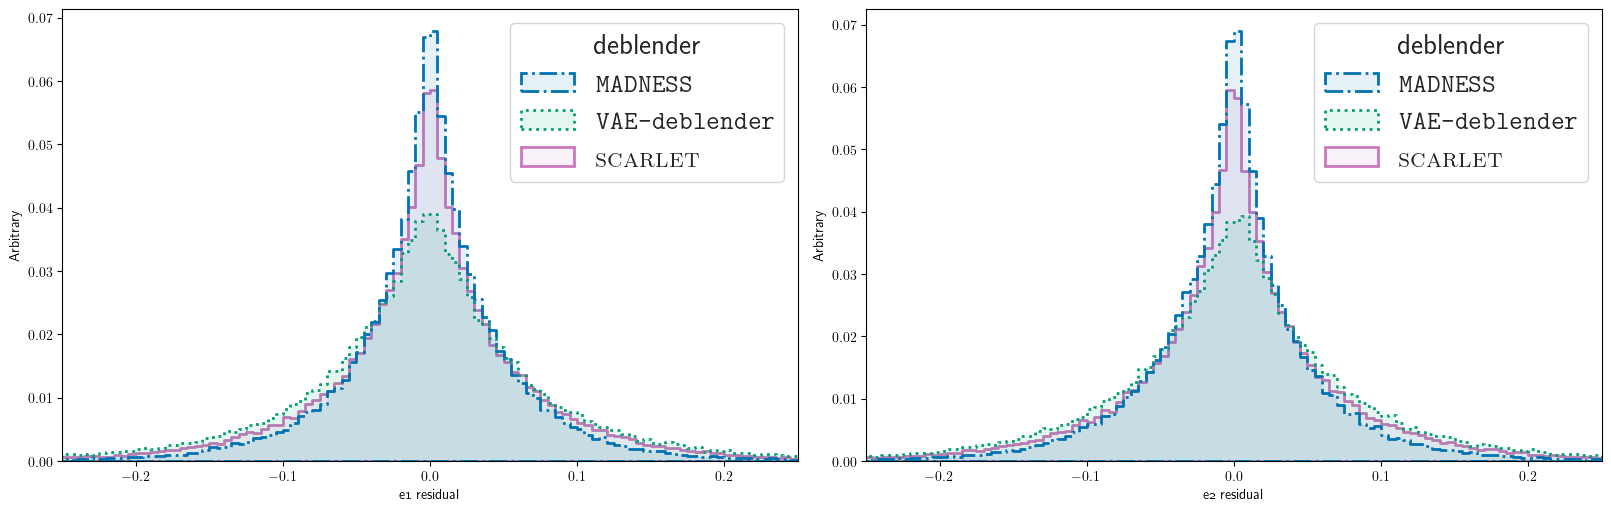

In [ ]:
fig = plt.figure(layout="constrained", figsize=(16, 5))
axes = fig.subplots(1, 2)

sns.set(font_scale=1.75)
sns.set_style("whitegrid", rc={"grid.color": ".85", "grid.linestyle": "--"})

lss = [madness_plot_ls, debvader_plot_ls, scarlet_plot_ls]
lcs = [madness_plot_color, debvader_plot_color, scarlet_plot_color]


for i in range(2):
    bins = np.arange(-0.5, 0.5, 0.005)
    p = sns.histplot(
        df_plot,
        bins=bins,
        x=f"e{i+1}_residual",
        hue="deblender",
        element="step",
        alpha=0.1,
        common_norm=False,
        palette=lcs,
        stat="probability",
        lw=2,
        ax=axes[i],
    )

    handles = p.legend_.legend_handles

    for line, ls, handle in zip(p.collections[::-1], lss, handles):
        line.set_linestyle(ls)
        handle.set_ls(ls)

    p.set_xlabel(rf"e\oldstylenums{i+1} residual")
    p.set_ylabel("Arbitrary")

    p.set_xlim((-0.25, 0.25))

plt.savefig(os.path.join("results", "high_density", "shapes.pdf"))

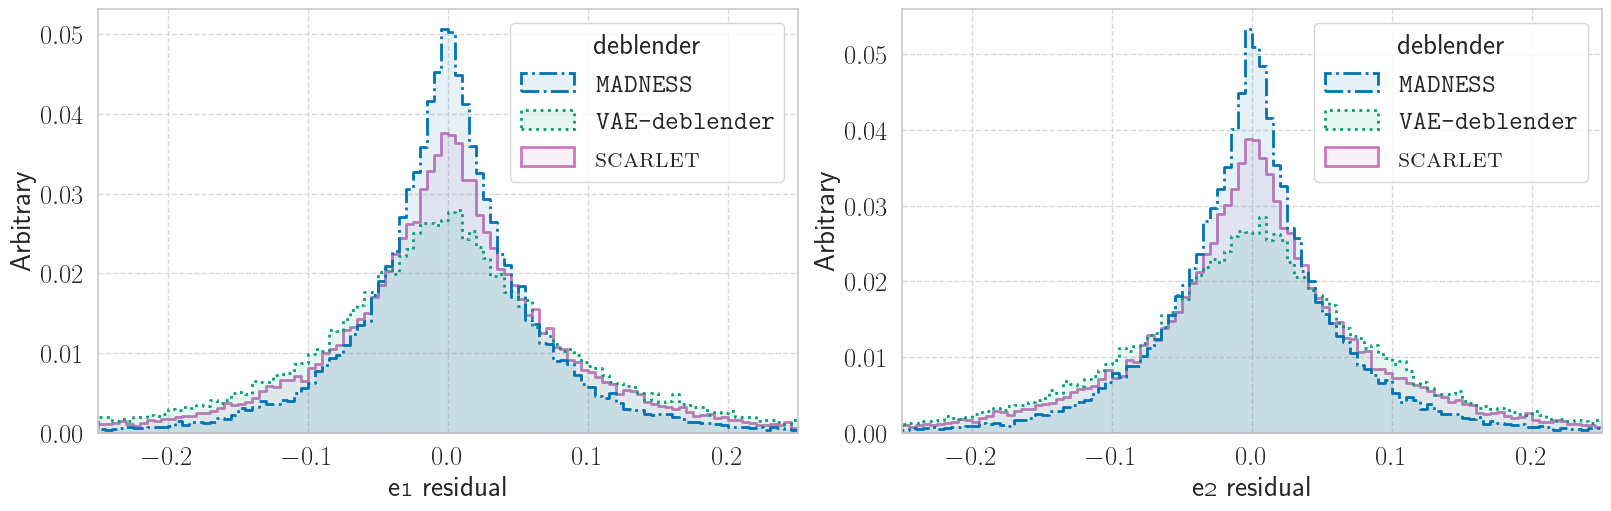

In [ ]:
mask = df_plot["contamination"] >= 0.01
fig = plt.figure(layout="constrained", figsize=(16, 5))
axes = fig.subplots(1, 2)

sns.set(font_scale=1.75)
sns.set_style("whitegrid", rc={"grid.color": ".85", "grid.linestyle": "--"})

lss = [madness_plot_ls, debvader_plot_ls, scarlet_plot_ls]
lcs = [madness_plot_color, debvader_plot_color, scarlet_plot_color]


for i in range(2):
    bins = np.arange(-0.5, 0.5, 0.005)
    p = sns.histplot(
        df_plot[mask],
        bins=bins,
        x=f"e{i+1}_residual",
        hue="deblender",
        element="step",
        alpha=0.1,
        common_norm=False,
        palette=lcs,
        stat="probability",
        lw=2,
        ax=axes[i],
    )

    handles = p.legend_.legend_handles

    for line, ls, handle in zip(p.collections[::-1], lss, handles):
        line.set_linestyle(ls)
        handle.set_ls(ls)

    p.set_xlabel(rf"e\oldstylenums{i+1} residual")
    p.set_ylabel("Arbitrary")

    p.set_xlim((-0.25, 0.25))
plt.savefig(os.path.join("results", "high_density", "shapes_cut.pdf"))

## Make a Gaussian fit

In [ ]:
def gauss(x, A, x0, sigma):
    return A * np.exp(-((x - x0) ** 2) / (2 * sigma**2))

In [ ]:
y, xedges = np.histogram(df_plot["e1_residual"])
xcenters = (xedges[:-1] + xedges[1:]) / 2

In [ ]:
for cut in ["cut", "uncut"]:
    if cut == "cut":
        df_masked = df_plot[mask]
        print("Results for entire dataset")
    else:
        df_masked = df_plot
        print(f"Results for galaxies in contamination greater than {contamination_cut}")

    for deblender in [madness_plot_label, scarlet_plot_label, debvader_plot_label]:

        print(rf"deblender {deblender}")
        df_deblender_masked = df_masked[df_masked["deblender"] == deblender]

        y, xedges = np.histogram(df_deblender_masked["e1_residual"], bins=20)
        xcenters = (xedges[:-1] + xedges[1:]) / 2

        print(y)
        print(xcenters)

        parameters, covariance = curve_fit(gauss, y, xcenters)
        print(parameters)

Results for entire dataset
deblender \texttt{MADNESS}
[    1     0     0     3    13    13    22    49    83   265  1649 16155
 18211  1785   303   103    61    33    16     8]
[-1.28433659 -1.17293425 -1.06153191 -0.95012957 -0.83872723 -0.72732489
 -0.61592255 -0.50452021 -0.39311787 -0.28171553 -0.17031319 -0.05891085
  0.05249149  0.16389383  0.27529617  0.38669851  0.49810085  0.60950319
  0.72090553  0.83230787]
[-1.34699692  1.26151562 -1.9782803 ]
deblender \textsc{scarlet}
[    3     3     2    13    47   128   383  1764  9287 21104  4713   929
   239    92    38    17     5     2     3     1]
[-0.942614   -0.83558835 -0.7285627  -0.62153705 -0.5145114  -0.40748575
 -0.30046009 -0.19343444 -0.08640879  0.02061686  0.12764251  0.23466816
  0.34169381  0.44871947  0.55574512  0.66277077  0.76979642  0.87682207
  0.98384772  1.09087338]
[1.47004131 1.24012944 0.31087493]
deblender \texttt{VAE-deblender}
[    3     2    10    25    62   125   414  1657  7068 19428  7464  1764
   4

In [ ]:
y, x_edges = np.histogram(df_plot["e1_residual"])
x = (x_edges[:-1] + x_edges[1:]) / 2

In [ ]:
x

array([-1.21445253, -0.96328205, -0.71211158, -0.4609411 , -0.20977063,
        0.04139985,  0.29257032,  0.54374079,  0.79491127,  1.04608174])

In [ ]:
parameters, covariance = curve_fit(gauss, x, y)

In [ ]:
parameters

array([2.63278564e+05, 1.08561953e-02, 1.04299112e-01])

In [ ]:
print(
    np.std(
        df_plot[mask]["e1_residual"][df_plot[mask]["deblender"] == madness_plot_label]
    )
)
print(
    np.std(
        df_plot[mask]["e1_residual"][df_plot[mask]["deblender"] == scarlet_plot_label]
    )
)

0.087496478138497
0.1007238032525488


In [ ]:
print(
    np.std(
        df_plot[mask]["e2_residual"][df_plot[mask]["deblender"] == madness_plot_label]
    )
)
print(
    np.std(
        df_plot[mask]["e2_residual"][df_plot[mask]["deblender"] == scarlet_plot_label]
    )
)

0.09309801252029536
0.10302726677507583


In [ ]:
np.sum(np.abs(df_plot["e1_actual"]) < 0.05) / 3

39786.0

(array([3.15000e+02, 2.01300e+03, 9.34500e+03, 3.55410e+04, 1.47921e+05,
        7.05150e+04, 1.77750e+04, 4.42800e+03, 7.86000e+02, 6.60000e+01]),
 array([-0.72039795, -0.56817892, -0.41595989, -0.26374087, -0.11152184,
         0.04069719,  0.19291621,  0.34513524,  0.49735427,  0.6495733 ,
         0.80179232]),
 <BarContainer object of 10 artists>)

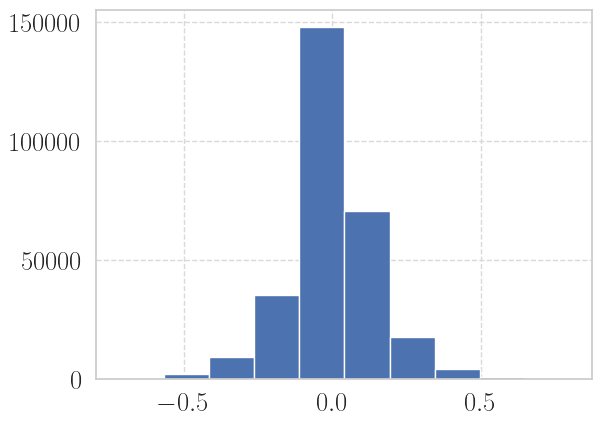

In [ ]:
plt.hist(df_plot["e1_actual"])

In [ ]:
# Box plots

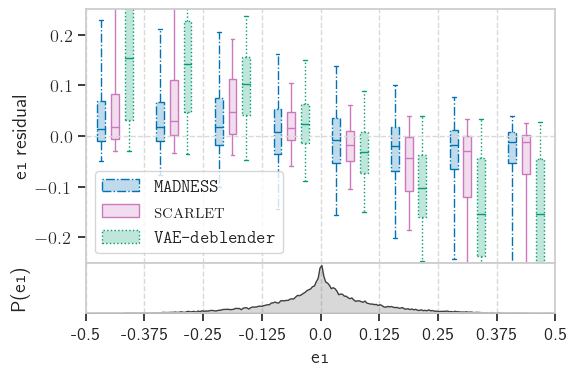

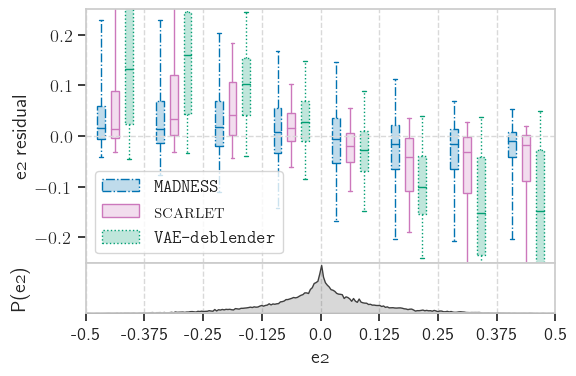

In [ ]:
x_lim = 0.5
nbins = 8
for i in range(2):
    (
        fig,
        median_e1_err,
        q1_e1_err,
        q3_e1_err,
        whislo_e1_err,
        whishi_e1_err,
    ) = madness_deblender.boxplot.boxplot_func(
        df_plot[mask],
        x=f"e{i+1}_actual",
        y=f"e{i+1}_residual",
        z="deblender",
        xlim=(-x_lim, x_lim),
        ylim=(-0.25, 0.25),
        x_scale=None,
        legend=[madness_plot_label, scarlet_plot_label, debvader_plot_label],
        x_label=rf"e\oldstylenums{i+1}",
        y_label=rf"e\oldstylenums{i+1} residual",
        y_label_hist=rf"P(e\oldstylenums{i+1})",
        legend_remove=False,
        legend_location="lower left",
        x_ticks=np.arange(-x_lim, x_lim + x_lim / nbins, 2 * x_lim / nbins),
        x_ticklabels=np.arange(-x_lim, x_lim + x_lim / nbins, 2 * x_lim / nbins),
        whis=[5, 95],
        percents=[25, 75],
        palette=[madness_plot_color, scarlet_plot_color, debvader_plot_color],  # 0.35,
        ls=[madness_plot_ls, scarlet_plot_ls, debvader_plot_ls],
        nbins=nbins,
        x_major_grid=True,
        sns_font_scale=1.2,
    )

    plt.savefig(
        os.path.join(
            "results", density_level + "_density", "temp", f"e{i+1}_box_plot.pdf"
        )
    )

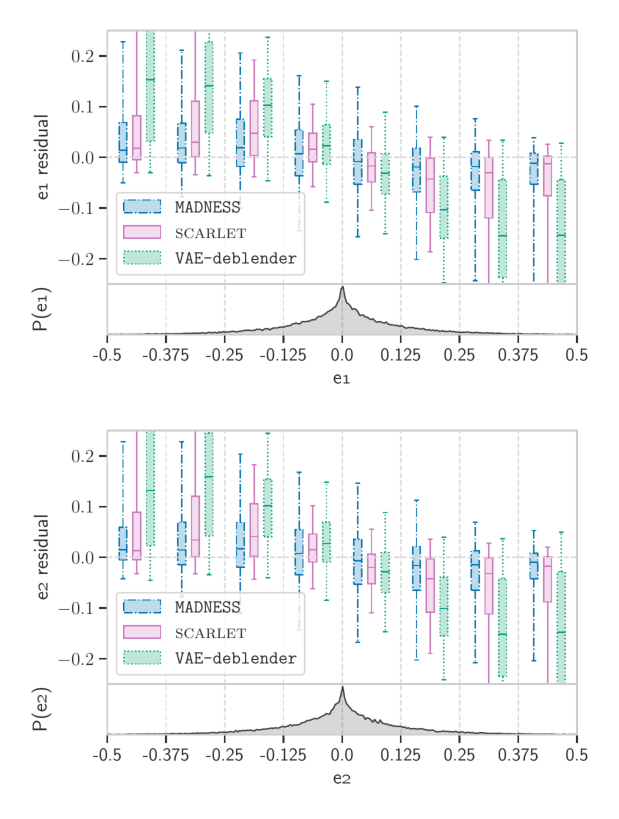

In [ ]:
f, axarr = plt.subplots(2, 1, figsize=(6, 8))

# axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))

axarr[0].imshow(
    convert_from_path(
        os.path.join("results", density_level + "_density", "temp", "e1_box_plot.pdf")
    )[0]
)
axarr[1].imshow(
    convert_from_path(
        os.path.join("results", density_level + "_density", "temp", "e2_box_plot.pdf")
    )[0]
)


# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)

plt.savefig(
    os.path.join("results", density_level + "_density", "shapes_boxplot_results.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        "results", density_level + "_density", "temp", "shapes_boxplot_results.png"
    )
)

plt.show()